<a href="https://colab.research.google.com/github/sunandhini96/ERA_S9/blob/main/ERA_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sunandhini96/ERA_S9.git

Cloning into 'ERA_S9'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 3.45 KiB | 1.72 MiB/s, done.


In [2]:
cd /content/ERA_S9

/content/ERA_S9


In [3]:
from ERA_S9 import *

## importing model

In [4]:
from model import *

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## defining train and test transformations

In [6]:

mean=(0.4914, 0.4822, 0.4465)
std=(0.2023, 0.1994, 0.2010)
def train_transform_function(mean,std):
  train_transform = A.Compose([A.HorizontalFlip(p=1),
                                       A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,rotate_limit=15,value=0),
                                       A.CoarseDropout(max_holes=1,max_height=16,  min_height=16, fill_value=mean, mask_fill_value = None),
                                        A.Normalize(mean,std),
                                       ToTensorV2()
                                       ])
  return lambda img:train_transform(image=np.array(img))["image"]

In [7]:


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [8]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_function(mean,std))
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 28709837.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=20, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Visualization

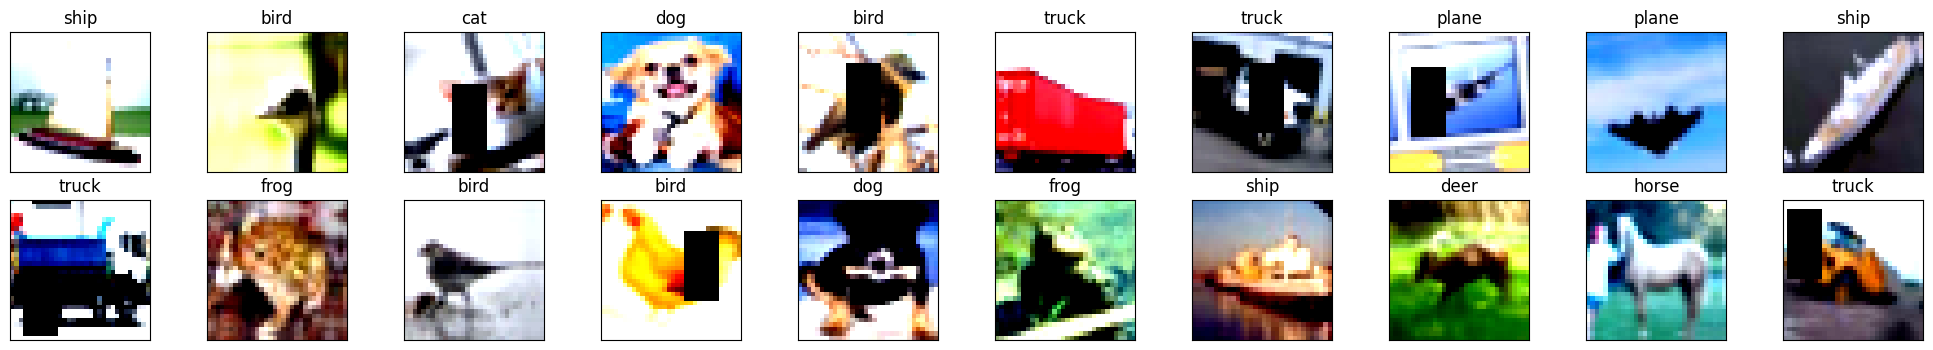

In [10]:
import matplotlib.pyplot as plt
import numpy as np


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img=img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#print(images.shape)

# show images
fig=plt.figure(figsize=(25,4))
#display 50 images
# Display 20 images
for idx in np.arange(20):
      ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]])

## Model

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
            Conv2d-2           [-1, 64, 30, 30]          18,432
              ReLU-3           [-1, 64, 30, 30]               0
       BatchNorm2d-4           [-1, 64, 30, 30]             128
           Dropout-5           [-1, 64, 30, 30]               0
            Conv2d-6           [-1, 64, 13, 13]             576
            Conv2d-7           [-1, 64, 13, 13]           4,096
depthwise_separable_conv-8           [-1, 64, 13, 13]               0
              ReLU-9           [-1, 64, 13, 13]               0
      BatchNorm2d-10           [-1, 64, 13, 13]             128
          Dropout-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]             576
           Conv2d-13          [-1, 128, 13, 13]           8,192
depthwise_separable_conv-14 

## Training and Testing loop

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training the model

In [14]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4477176666259766 Batch_id=2499 Accuracy=42.07: 100%|██████████| 2500/2500 [00:51<00:00, 48.68it/s]



Test set: Average loss: 1.2062, Accuracy: 5647/10000 (56.47%)

EPOCH: 1


Loss=0.7445029020309448 Batch_id=2499 Accuracy=54.19: 100%|██████████| 2500/2500 [00:40<00:00, 61.32it/s]



Test set: Average loss: 1.0482, Accuracy: 6254/10000 (62.54%)

EPOCH: 2


Loss=1.3236591815948486 Batch_id=2499 Accuracy=59.10: 100%|██████████| 2500/2500 [00:43<00:00, 56.86it/s]



Test set: Average loss: 0.9421, Accuracy: 6678/10000 (66.78%)

EPOCH: 3


Loss=1.0979433059692383 Batch_id=2499 Accuracy=62.55: 100%|██████████| 2500/2500 [00:44<00:00, 55.96it/s]



Test set: Average loss: 0.8445, Accuracy: 7066/10000 (70.66%)

EPOCH: 4


Loss=0.7958625555038452 Batch_id=2499 Accuracy=65.12: 100%|██████████| 2500/2500 [00:43<00:00, 56.89it/s]



Test set: Average loss: 0.7915, Accuracy: 7263/10000 (72.63%)

EPOCH: 5


Loss=1.191933512687683 Batch_id=2499 Accuracy=67.36: 100%|██████████| 2500/2500 [00:41<00:00, 60.46it/s]



Test set: Average loss: 0.7324, Accuracy: 7430/10000 (74.30%)

EPOCH: 6


Loss=1.0778263807296753 Batch_id=2499 Accuracy=71.64: 100%|██████████| 2500/2500 [00:41<00:00, 59.80it/s]



Test set: Average loss: 0.6620, Accuracy: 7691/10000 (76.91%)

EPOCH: 7


Loss=0.6711398363113403 Batch_id=2499 Accuracy=72.75: 100%|██████████| 2500/2500 [00:42<00:00, 58.86it/s]



Test set: Average loss: 0.6499, Accuracy: 7733/10000 (77.33%)

EPOCH: 8


Loss=0.6924811601638794 Batch_id=2499 Accuracy=73.26: 100%|██████████| 2500/2500 [00:41<00:00, 59.62it/s]



Test set: Average loss: 0.6493, Accuracy: 7755/10000 (77.55%)

EPOCH: 9


Loss=1.0327197313308716 Batch_id=2499 Accuracy=73.44: 100%|██████████| 2500/2500 [00:41<00:00, 59.89it/s]



Test set: Average loss: 0.6445, Accuracy: 7758/10000 (77.58%)

EPOCH: 10


Loss=0.6760246753692627 Batch_id=2499 Accuracy=73.70: 100%|██████████| 2500/2500 [00:42<00:00, 58.80it/s]



Test set: Average loss: 0.6218, Accuracy: 7842/10000 (78.42%)

EPOCH: 11


Loss=0.6267181038856506 Batch_id=2499 Accuracy=74.14: 100%|██████████| 2500/2500 [00:41<00:00, 60.76it/s]



Test set: Average loss: 0.6272, Accuracy: 7838/10000 (78.38%)

EPOCH: 12


Loss=0.3734281063079834 Batch_id=2499 Accuracy=74.55: 100%|██████████| 2500/2500 [00:40<00:00, 62.21it/s]



Test set: Average loss: 0.6264, Accuracy: 7825/10000 (78.25%)

EPOCH: 13


Loss=0.5710800886154175 Batch_id=2499 Accuracy=74.77: 100%|██████████| 2500/2500 [00:40<00:00, 61.86it/s]



Test set: Average loss: 0.6282, Accuracy: 7818/10000 (78.18%)

EPOCH: 14


Loss=0.41047829389572144 Batch_id=2499 Accuracy=74.94: 100%|██████████| 2500/2500 [00:40<00:00, 62.50it/s]



Test set: Average loss: 0.6213, Accuracy: 7840/10000 (78.40%)

EPOCH: 15


Loss=0.8619778752326965 Batch_id=2499 Accuracy=74.98: 100%|██████████| 2500/2500 [00:40<00:00, 61.86it/s]



Test set: Average loss: 0.6205, Accuracy: 7850/10000 (78.50%)

EPOCH: 16


Loss=0.4443906843662262 Batch_id=2499 Accuracy=74.81: 100%|██████████| 2500/2500 [00:42<00:00, 59.10it/s]



Test set: Average loss: 0.6133, Accuracy: 7860/10000 (78.60%)

EPOCH: 17


Loss=0.9082814455032349 Batch_id=2499 Accuracy=74.87: 100%|██████████| 2500/2500 [00:39<00:00, 62.65it/s]



Test set: Average loss: 0.6132, Accuracy: 7858/10000 (78.58%)

EPOCH: 18


Loss=0.8627544641494751 Batch_id=2499 Accuracy=75.03: 100%|██████████| 2500/2500 [00:39<00:00, 62.74it/s]



Test set: Average loss: 0.6129, Accuracy: 7870/10000 (78.70%)

EPOCH: 19


Loss=0.6837628483772278 Batch_id=2499 Accuracy=74.81: 100%|██████████| 2500/2500 [00:38<00:00, 64.22it/s]



Test set: Average loss: 0.6178, Accuracy: 7858/10000 (78.58%)

EPOCH: 20


Loss=0.35010239481925964 Batch_id=2499 Accuracy=75.05: 100%|██████████| 2500/2500 [00:40<00:00, 62.40it/s]



Test set: Average loss: 0.6093, Accuracy: 7876/10000 (78.76%)

EPOCH: 21


Loss=0.673524022102356 Batch_id=2499 Accuracy=74.88: 100%|██████████| 2500/2500 [00:41<00:00, 60.82it/s]



Test set: Average loss: 0.6089, Accuracy: 7885/10000 (78.85%)

EPOCH: 22


Loss=0.8565679788589478 Batch_id=2499 Accuracy=74.60: 100%|██████████| 2500/2500 [00:40<00:00, 62.40it/s]



Test set: Average loss: 0.6124, Accuracy: 7863/10000 (78.63%)

EPOCH: 23


Loss=0.6207696795463562 Batch_id=2499 Accuracy=74.95: 100%|██████████| 2500/2500 [00:40<00:00, 62.01it/s]



Test set: Average loss: 0.6159, Accuracy: 7862/10000 (78.62%)

EPOCH: 24


Loss=0.9910368919372559 Batch_id=2499 Accuracy=75.00: 100%|██████████| 2500/2500 [00:39<00:00, 62.61it/s]



Test set: Average loss: 0.6230, Accuracy: 7849/10000 (78.49%)

EPOCH: 25


Loss=0.535527229309082 Batch_id=2499 Accuracy=74.95: 100%|██████████| 2500/2500 [00:40<00:00, 60.99it/s]



Test set: Average loss: 0.6130, Accuracy: 7856/10000 (78.56%)

EPOCH: 26


Loss=0.39001351594924927 Batch_id=2499 Accuracy=75.09: 100%|██████████| 2500/2500 [00:40<00:00, 62.38it/s]



Test set: Average loss: 0.6177, Accuracy: 7874/10000 (78.74%)

EPOCH: 27


Loss=0.6399223804473877 Batch_id=2499 Accuracy=75.12: 100%|██████████| 2500/2500 [00:42<00:00, 59.38it/s]



Test set: Average loss: 0.6125, Accuracy: 7885/10000 (78.85%)

EPOCH: 28


Loss=0.7416540384292603 Batch_id=2499 Accuracy=75.05: 100%|██████████| 2500/2500 [00:42<00:00, 59.51it/s]



Test set: Average loss: 0.6232, Accuracy: 7835/10000 (78.35%)

EPOCH: 29


Loss=0.6271716356277466 Batch_id=2499 Accuracy=74.82: 100%|██████████| 2500/2500 [00:42<00:00, 58.81it/s]



Test set: Average loss: 0.6152, Accuracy: 7862/10000 (78.62%)

EPOCH: 30


Loss=0.5710423588752747 Batch_id=2499 Accuracy=74.87: 100%|██████████| 2500/2500 [00:42<00:00, 58.26it/s]



Test set: Average loss: 0.6156, Accuracy: 7848/10000 (78.48%)

EPOCH: 31


Loss=0.6686573624610901 Batch_id=2499 Accuracy=75.30: 100%|██████████| 2500/2500 [00:42<00:00, 59.03it/s]



Test set: Average loss: 0.6080, Accuracy: 7875/10000 (78.75%)

EPOCH: 32


Loss=0.6097737550735474 Batch_id=2499 Accuracy=75.08: 100%|██████████| 2500/2500 [00:41<00:00, 59.63it/s]



Test set: Average loss: 0.6208, Accuracy: 7854/10000 (78.54%)

EPOCH: 33


Loss=0.579014241695404 Batch_id=2499 Accuracy=75.16: 100%|██████████| 2500/2500 [00:41<00:00, 60.53it/s]



Test set: Average loss: 0.6113, Accuracy: 7855/10000 (78.55%)

EPOCH: 34


Loss=0.27706533670425415 Batch_id=2499 Accuracy=74.91: 100%|██████████| 2500/2500 [00:42<00:00, 58.79it/s]



Test set: Average loss: 0.6144, Accuracy: 7851/10000 (78.51%)

EPOCH: 35


Loss=0.7016671895980835 Batch_id=2499 Accuracy=74.98: 100%|██████████| 2500/2500 [00:42<00:00, 59.18it/s]



Test set: Average loss: 0.6126, Accuracy: 7859/10000 (78.59%)

EPOCH: 36


Loss=0.7023204565048218 Batch_id=2499 Accuracy=75.05: 100%|██████████| 2500/2500 [00:41<00:00, 59.75it/s]



Test set: Average loss: 0.6189, Accuracy: 7841/10000 (78.41%)

EPOCH: 37


Loss=0.6442255973815918 Batch_id=2499 Accuracy=74.99: 100%|██████████| 2500/2500 [00:41<00:00, 59.72it/s]



Test set: Average loss: 0.6130, Accuracy: 7862/10000 (78.62%)

EPOCH: 38


Loss=0.6742684841156006 Batch_id=2499 Accuracy=75.11: 100%|██████████| 2500/2500 [00:42<00:00, 58.79it/s]



Test set: Average loss: 0.6093, Accuracy: 7879/10000 (78.79%)

EPOCH: 39


Loss=0.8128570318222046 Batch_id=2499 Accuracy=74.81: 100%|██████████| 2500/2500 [00:42<00:00, 58.61it/s]



Test set: Average loss: 0.6188, Accuracy: 7854/10000 (78.54%)



In [15]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), dilation=(2, 2), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): depthwise_separable_conv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (5): ReLU(

In [16]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 7
conv_layers


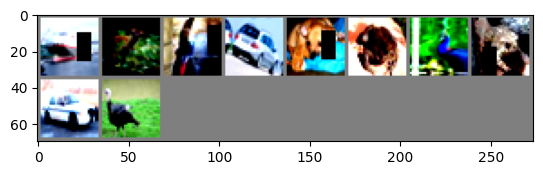

In [17]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

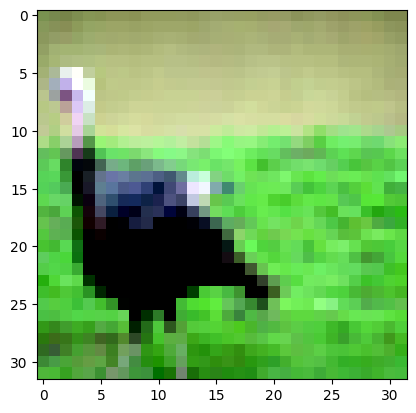

In [18]:
image = images[9]
imshow(image)

In [19]:
image = image.unsqueeze(0)
image = image.to(device)

## Loss and Accuracy curves

Text(0.5, 1.0, 'Test Accuracy')

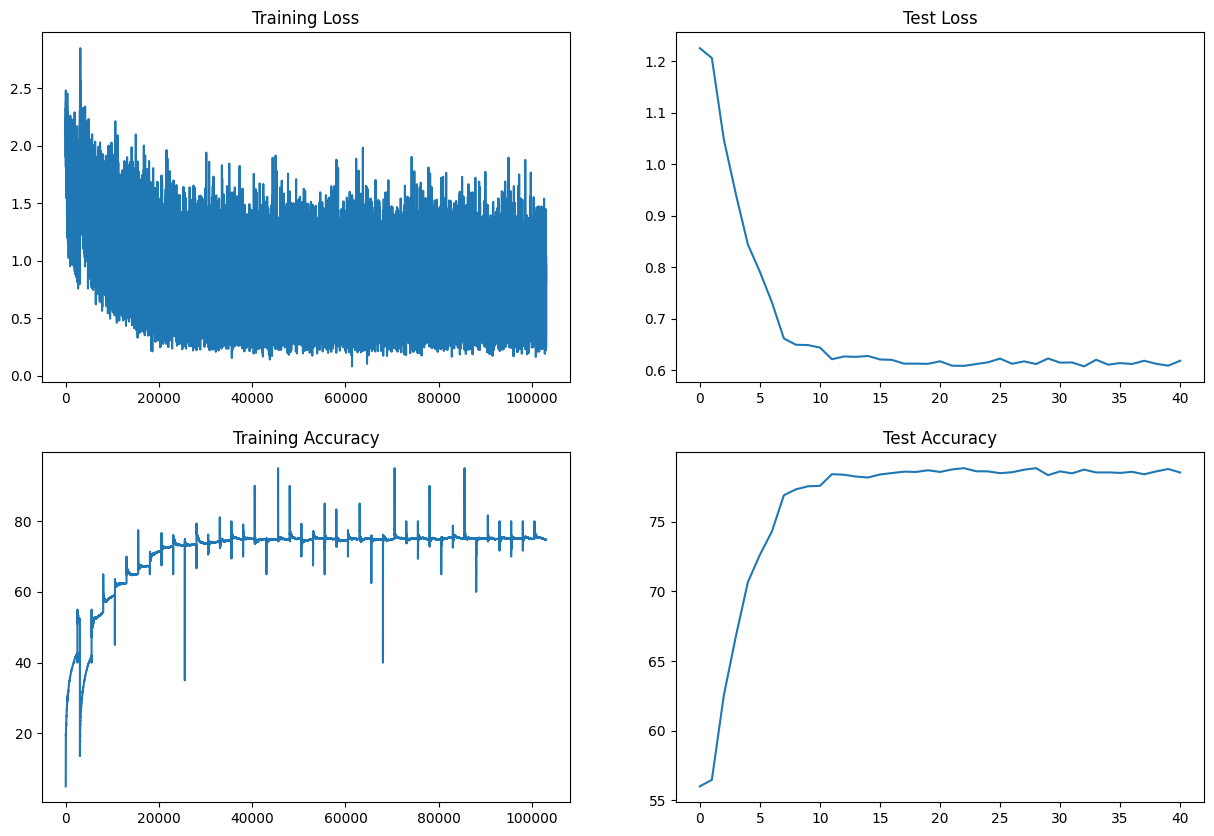

In [25]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")